# Exercises - Forward Rates

#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$

This exercise builds on the bootstrapped spot curve to calculate forward rates.

### Data

Use the bootstrapped spot curve from the data file:
`data/treasury_quotes_2025-11-28.xlsx`, sheet `selected quotes`

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

### 1.1. Bootstrap the Spot Curve

Using the selected quotes (approximately 6-month intervals), bootstrap the spot curve.

Report for maturity T=5:
* The discount factor
* The semiannually-compounded spot rate
* The continuously-compounded spot rate

Round to 4 decimal places.

In [2]:
data = pd.read_excel("treasury_quotes_2025-11-28.xlsx", sheet_name="selected quotes",
                     parse_dates=["quote date", "issue date", "maturity date"])
data.head()

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
0,208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
1,208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
2,208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
3,208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
4,208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588


In [ ]:
# Build cashflow matrix (from E.1.1)
def treasury_cashflow_dates(issue, maturity):
    dates = (pd.date_range(
        start=issue,
        end=maturity,
        freq="6MS"
    ) - pd.Timedelta(days=1))

    if (maturity + MonthEnd(0)) not in dates:
        dates = dates.append(pd.DatetimeIndex([maturity + MonthEnd(0)]))

    return dates

all_dates = pd.to_datetime(sorted(
    set(
        date
        for _, row in data.iterrows()
        for date in treasury_cashflow_dates(row['issue date'], row['maturity date'])
    )
))

FACE = 100
C = pd.DataFrame(0.0, index=data.index, columns=all_dates)

for i, row in data.iterrows():
    coupon_payment = FACE * row['cpn rate'] / 100 / 2
    payment_dates = treasury_cashflow_dates(row["issue date"], row["maturity date"])

    for d in payment_dates:
        C.loc[i, d] += coupon_payment

    C.loc[i, row["maturity date"] + MonthEnd(0)] += FACE

# Filter to dates with maturities only
C = C.loc[:, (C > FACE).any()]

# Solve for discount factors
p = data["price"].astype(float).to_numpy()
z_hat, _, _, _ = np.linalg.lstsq(C.to_numpy(), p, rcond=None)
z = pd.Series(z_hat, index=C.columns, name="discount_factor")

# Compute time to maturity for each date
# ttm = (C.columns - quote_date).days / 365.25
ttm = data["ttm"].values

# Compute spot rates
r_sa = 2 * (z.values ** (-1 / (2 * ttm)) - 1)  # semiannually compounded
r_cc = -np.log(z.values) / ttm                  # continuously compounded

# Create results dataframe
spot_curve = pd.DataFrame({
    'T': ttm,
    'discount_factor': z.values,
    'spot_rate_semi': r_sa,
    'spot_rate_cont': r_cc
}, index=C.columns)

# spot_curve = spot_curve[spot_curve['T'] > 0.25]

spot_curve

,T,discount_factor,spot_rate_semi,spot_rate_cont
2026-05-31,0.503765,0.981343,0.037737,0.037385
2026-11-30,1.004791,0.964472,0.036328,0.036002
2027-05-31,1.503080,0.948551,0.035452,0.035141
2027-11-30,2.004107,0.933088,0.034857,0.034557
2028-05-31,2.505133,0.917225,0.034789,0.034490
2028-11-30,3.006160,0.901050,0.034962,0.034660
2029-05-31,3.504449,0.884954,0.035181,0.034876
2029-11-30,4.005476,0.868448,0.035526,0.035214
2030-05-31,4.503765,0.852545,0.035737,0.035421
2030-11-30,5.004791,0.836465,0.036000,0.035680


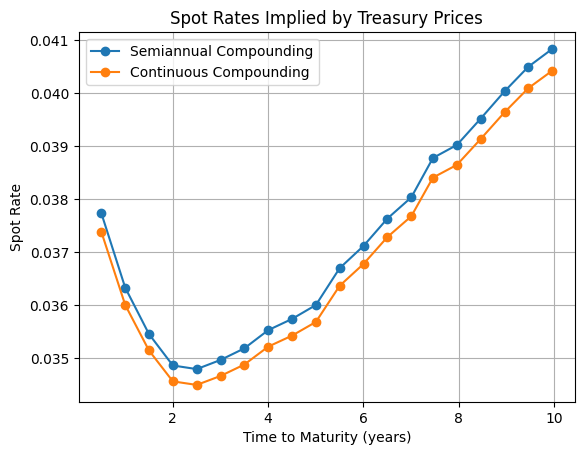

In [4]:
plt.figure()
plt.plot(spot_curve["T"], spot_curve["spot_rate_semi"], marker="o", label="Semiannual Compounding")
plt.plot(spot_curve["T"], spot_curve["spot_rate_cont"], marker="o", label="Continuous Compounding")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Spot Rate")
plt.title("Spot Rates Implied by Treasury Prices")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Find the row closest to T=5
idx_T5 = (spot_curve['T'] - 5).abs().idxmin()
row_T5 = spot_curve.loc[idx_T5]

print(f"Discount factor:              {row_T5['discount_factor']:.4f}")
print(f"Spot rate (semi-annual):      {row_T5['spot_rate_semi']:.4f}")
print(f"Spot rate (continuous):       {row_T5['spot_rate_cont']:.4f}")

Discount factor:              0.8365
Spot rate (semi-annual):      0.0360
Spot rate (continuous):       0.0357


### 1.2. Forward Discount Factors

Using the spot curve, calculate the 6-month forward discount factors:

$$F(0, T, T+0.5) = \frac{Z(0, T+0.5)}{Z(0, T)}$$

Report a table with columns:
* `T` (starting maturity)
* `forward discount` 
* `forward rate (semi-annual)`
* `forward rate (continuous)`

For T=5 to T=5.5, report all three values rounded to 4 decimal places.

In [6]:
spot_curve.head(3)

,T,discount_factor,spot_rate_semi,spot_rate_cont
2026-05-31,0.503765,0.981343,0.037737,0.037385
2026-11-30,1.004791,0.964472,0.036328,0.036002
2027-05-31,1.503080,0.948551,0.035452,0.035141


In [7]:
def forward_discount_factors(spot_curve, t):

    if t >= len(spot_curve) - 1:
        return np.nan

    zero_discount_factor = spot_curve.iloc[t]["discount_factor"]
    tplus05_discount_factor = spot_curve.iloc[t+1]["discount_factor"]

    return  tplus05_discount_factor / zero_discount_factor

spot_curve['forward_discount'] = [forward_discount_factors(spot_curve, i) for i in range(len(spot_curve))]
spot_curve['forward_rate_semi'] = 2 * (1 / spot_curve['forward_discount'] - 1)
spot_curve['forward_rate_cont'] = -np.log(spot_curve['forward_discount']) / 0.5

spot_curve.head(11)

,T,discount_factor,spot_rate_semi,spot_rate_cont,forward_discount,forward_rate_semi,forward_rate_cont
2026-05-31,0.503765,0.981343,0.037737,0.037385,0.982808,0.034986,0.034683
2026-11-30,1.004791,0.964472,0.036328,0.036002,0.983493,0.033569,0.033291
2027-05-31,1.503080,0.948551,0.035452,0.035141,0.983698,0.033144,0.032872
2027-11-30,2.004107,0.933088,0.034857,0.034557,0.983000,0.034587,0.034292
2028-05-31,2.505133,0.917225,0.034789,0.034490,0.982365,0.035902,0.035584
2028-11-30,3.006160,0.901050,0.034962,0.034660,0.982136,0.036378,0.036051
2029-05-31,3.504449,0.884954,0.035181,0.034876,0.981348,0.038014,0.037657
2029-11-30,4.005476,0.868448,0.035526,0.035214,0.981688,0.037307,0.036963
2030-05-31,4.503765,0.852545,0.035737,0.035421,0.981140,0.038446,0.038081
2030-11-30,5.004791,0.836465,0.036000,0.035680,0.978690,0.043549,0.043081


In [9]:
row = spot_curve.loc['2030-11-30']

print(f"Results for T = {row['T']:.4f} years (2030-11-30):")
print(f"  Forward discount       : {row['forward_discount']:.4f}")
print(f"  Forward rate (semi-annual): {row['forward_rate_semi']:.4f}")
print(f"  Forward rate (continuous) : {row['forward_rate_cont']:.4f}")

Results for T = 5.0048 years (2030-11-30):
  Forward discount       : 0.9787
  Forward rate (semi-annual): 0.0435
  Forward rate (continuous) : 0.0431


### 1.3. Forward Curve Analysis

1. Plot the spot rate curve and the 6-month forward rate curve on the same axes.

2. For which maturity interval $(T_1, T_2)$ is the forward rate highest?

3. At maturities where the forward rate is above the spot rate, what does this imply about the slope of the spot curve?

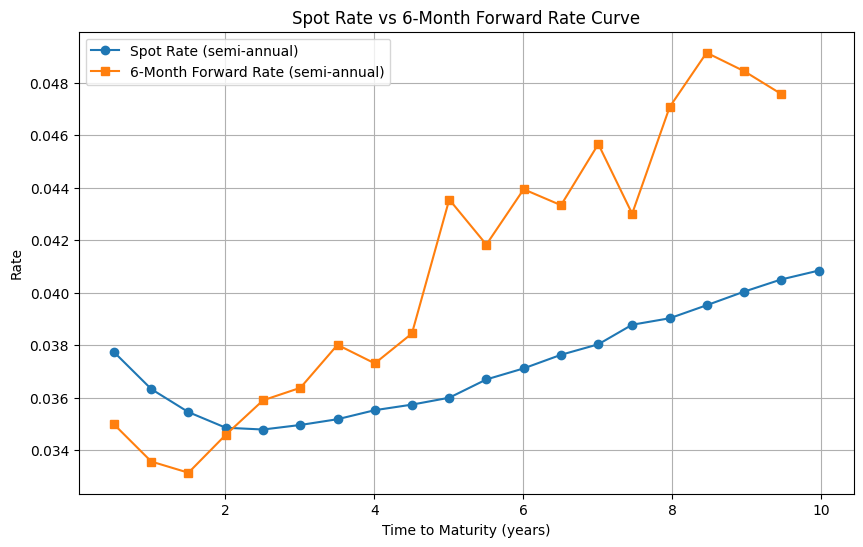

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(spot_curve["T"], spot_curve["spot_rate_semi"], marker="o", label="Spot Rate (semi-annual)")

plt.plot(spot_curve["T"], spot_curve["forward_rate_semi"], marker="s", label="6-Month Forward Rate (semi-annual)")

plt.xlabel("Time to Maturity (years)")
plt.ylabel("Rate")
plt.title("Spot Rate vs 6-Month Forward Rate Curve")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def highest_forward_rate(spot_curve):
    highest_rate = 0
    for x in range(len(spot_curve)):
        if spot_curve['forward_rate_semi'].iloc[x] > highest_rate:
            highest_rate = spot_curve['forward_rate_semi'].iloc[x]
            T_1 = spot_curve['T'].iloc[x]
            T_2 = spot_curve['T'].iloc[x+1]
    return highest_rate, T_1, T_2

rate, T_1, T_2 = highest_forward_rate(spot_curve)
print(f"\nHighest forward rate is for interval (T1={T_1:.4f}, T2={T_2:.4f})")
print(f"Forward rate: {rate:.6f}")




Highest forward rate is for interval (T1=8.4600, T2=8.9637)
Forward rate: 0.049138


### 1.3 - 3

The slope must be positive when the forward rate is above the spot rate. 

***